In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 3) Practical: MAP Estimation for simple regression problem 

## 3D)

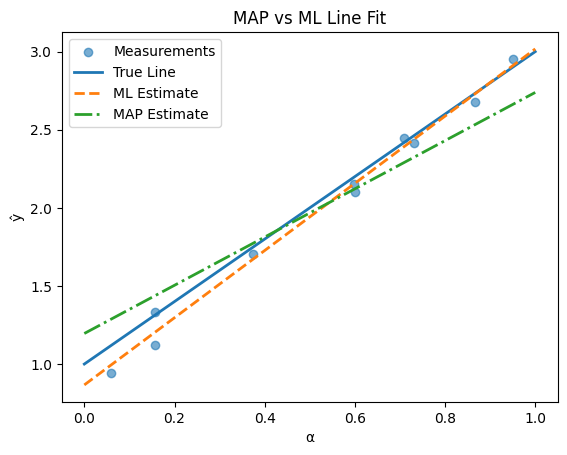

The MAP and ML estimates are quite similar, where the MAP estimate has a bit more of an offsetto the true line compared to the MLE estimate 


In [47]:
# Reuse the same setup as Week 8
np.random.seed(42)

# True parameters
yI_true = 1.0
yF_true = 3.0
sigma_v2 = 0.01
sigma_v = np.sqrt(sigma_v2)
M = 10

# Generate measurements
alpha = np.random.rand(M)
y_hat = (1 - alpha) * yI_true + alpha * yF_true + np.random.randn(M) * sigma_v

# ML Estimate (reuse from Week 8)
A_ml = np.vstack([
    np.vstack([(1 - alpha) ** 2, alpha * (1 - alpha)]),
    np.vstack([alpha * (1 - alpha), alpha ** 2])
]).reshape(2, 2, -1).sum(axis=2)

b_ml = np.array([
    np.sum((1 - alpha) * y_hat),
    np.sum(alpha * y_hat)
])
theta_ml = np.linalg.solve(A_ml, b_ml)

# MAP Estimate — use prior: N(yI; μI, σI^2), N(yF; μF, σF^2)
mu_I, sigma_I2 = 1.5, 0.5
mu_F, sigma_F2 = 2.5, 0.5

# Calculating the augmented A and b for MAP
A_map = A_ml + np.array([
    [1 / sigma_I2, 0],
    [0, 1 / sigma_F2]
])

b_map = b_ml + np.array([
    mu_I / sigma_I2,
    mu_F / sigma_F2
])

theta_map = np.linalg.solve(A_map, b_map)

# Plot actual line, measurements, ML and MAP estimates
alpha_line = np.linspace(0, 1, 200)
y_true = (1 - alpha_line) * yI_true + alpha_line * yF_true
y_ml = (1 - alpha_line) * theta_ml[0] + alpha_line * theta_ml[1]
y_map = (1 - alpha_line) * theta_map[0] + alpha_line * theta_map[1]

plt.figure()
plt.scatter(alpha, y_hat, label="Measurements", alpha=0.6)
plt.plot(alpha_line, y_true, label="True Line", linewidth=2)
plt.plot(alpha_line, y_ml, "--", label="ML Estimate", linewidth=2)
plt.plot(alpha_line, y_map, "-.", label="MAP Estimate", linewidth=2)
plt.xlabel("α")
plt.ylabel("ŷ")
plt.title("MAP vs ML Line Fit")
plt.legend()
plt.show()

print("The MAP and ML estimates are quite similar, where the MAP estimate has a bit more of an offset" \
"to the true line compared to the MLE estimate ")

## 3E) repeat sampling and parameter estimation, but vary number of Measurements

### i) smallest number of measurements needed to calculate MAP
- 0, there can be no measurements and the MAP will still be calculable becuase of the regularisation parameter added by the prior in the MAP estimates

### ii) effect number of data points have on the difference between the MAP and ML Estimate
- th more data points there is the MAP and MLE estimates start to approach each other and consequently start to approach the true line. The inverse is also true however, as the number of data points decreases the estimates for MAP end MLE start diverging from each other

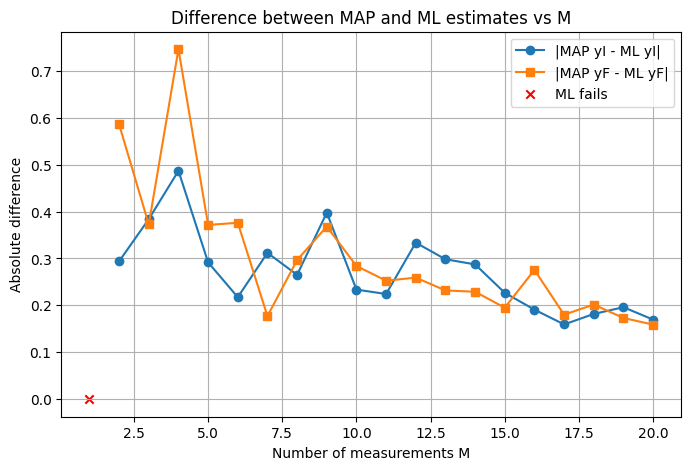

Smallest M for MAP estimate: 1
Smallest M for ML estimate: 2


In [48]:
# True parameters and priors
yI_true, yF_true = 1.0, 3.0
sigma_v2 = 0.01
sigma_v = np.sqrt(sigma_v2)
mu_I, sigma_I2 = 1.5, 0.5
mu_F, sigma_F2 = 2.5, 0.5

# Range of measurement counts to test
M_values = np.arange(1, 21)

# Storage for estimates and failures
theta_ml_list = []
theta_map_list = []
ml_success = []

# Use fixed RNG for reproducibility
rng = np.random.RandomState(42)

for M in M_values:
    # Generate data
    alpha = rng.rand(M)
    y_hat = (1 - alpha) * yI_true + alpha * yF_true + rng.randn(M) * sigma_v
    
    # ML estimate
    A_ml = np.vstack([
        np.vstack([(1 - alpha)**2, alpha * (1 - alpha)]),
        np.vstack([alpha * (1 - alpha), alpha**2])
    ]).reshape(2, 2, -1).sum(axis=2)
    b_ml = np.array([
        np.sum((1 - alpha) * y_hat),
        np.sum(alpha * y_hat)
    ])
    try:
        theta_ml = np.linalg.solve(A_ml, b_ml)
        ml_success.append(True)
    except np.linalg.LinAlgError:
        theta_ml = np.array([np.nan, np.nan])
        ml_success.append(False)
    
    # MAP estimate
    A_map = A_ml + np.array([[1/sigma_I2, 0], [0, 1/sigma_F2]])
    b_map = b_ml + np.array([mu_I/sigma_I2, mu_F/sigma_F2])
    theta_map = np.linalg.solve(A_map, b_map)
    
    theta_ml_list.append(theta_ml)
    theta_map_list.append(theta_map)

theta_ml_arr = np.array(theta_ml_list)
theta_map_arr = np.array(theta_map_list)

# Compute absolute differences
diff_yI = np.abs(theta_map_arr[:,0] - theta_ml_arr[:,0])
diff_yF = np.abs(theta_map_arr[:,1] - theta_ml_arr[:,1])

# Plotting
plt.figure(figsize=(8,5))
plt.plot(M_values, diff_yI, marker='o', label='|MAP yI - ML yI|')
plt.plot(M_values, diff_yF, marker='s', label='|MAP yF - ML yF|')
for i, success in enumerate(ml_success):
    if not success:
        plt.scatter(M_values[i], 0, color='red', marker='x', label='ML fails' if 'ML fails' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Number of measurements M')
plt.ylabel('Absolute difference')
plt.title('Difference between MAP and ML estimates vs M')
plt.legend()
plt.grid(True)
plt.show()

# Print smallest M for MAP and ML
M_map = M_values[0]  # MAP works from M=1
M_ml = M_values[next(i for i,s in enumerate(ml_success) if s)]
print(f"Smallest M for MAP estimate: {M_map}")
print(f"Smallest M for ML estimate: {M_ml}")


## 3F) Keep M fixed but vary the measurement noise variance

### i) influence of covariance parameter on the MAP and MLE estimates
- the influence of the covariance on the MAP and MLE Estimates depends on the number of data points. For a larger number of datapoints the effect of the covariance on the difference between these estimates is neglible or rather not that larger. However for fewer number of data points the covariance increases the diffence between the estimates

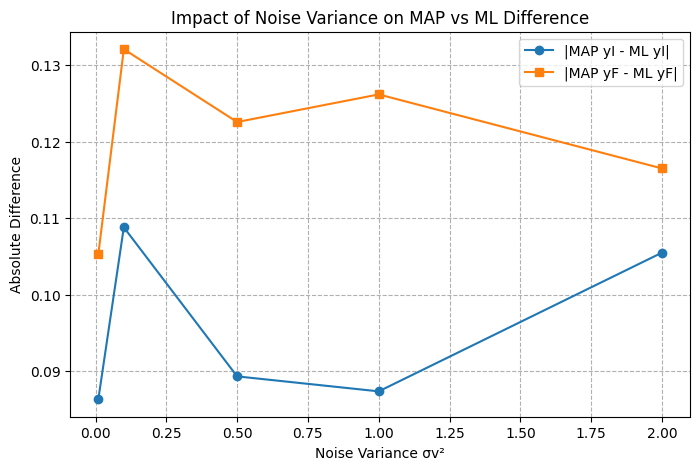

In [56]:
# Fixed number of measurements
M = 50
yI_true, yF_true = 1.0, 3.0

# Prior parameters
mu_I, sigma_I2 = 1.5, 0.5
mu_F, sigma_F2 = 2.5, 0.5

# Noise variances to test
noise_variances = [0.01, 0.1, 0.5, 1.0, 2.0]

# Storage for differences
diff_I = []
diff_F = []

# Ensure reproducibility
rng = np.random.RandomState(42)
alpha = rng.rand(M)

for sigma_v2 in noise_variances:
    sigma_v = np.sqrt(sigma_v2)
    y_hat = (1 - alpha) * yI_true + alpha * yF_true + rng.randn(M) * sigma_v
    
    # ML estimation
    A_ml = sum(np.array([[ (1-a)**2, a*(1-a)], [a*(1-a), a**2 ]]) for a in alpha)
    b_ml = np.array([np.sum((1-alpha)*y_hat), np.sum(alpha*y_hat)])
    theta_ml = np.linalg.solve(A_ml, b_ml)
    
    # MAP estimation
    A_map = A_ml + np.diag([1/sigma_I2, 1/sigma_F2])
    b_map = b_ml + np.array([mu_I/sigma_I2, mu_F/sigma_F2])
    theta_map = np.linalg.solve(A_map, b_map)
    
    diff_I.append(abs(theta_map[0] - theta_ml[0]))
    diff_F.append(abs(theta_map[1] - theta_ml[1]))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(noise_variances, diff_I, marker='o', label='|MAP yI - ML yI|')
plt.plot(noise_variances, diff_F, marker='s', label='|MAP yF - ML yF|')
plt.xlabel('Noise Variance σv²')
plt.ylabel('Absolute Difference')
plt.title('Impact of Noise Variance on MAP vs ML Difference')
plt.legend()
plt.grid(True, ls='--')
plt.show()


# 4) Practical: Full Bayesian estimation for a simple regression example

## 4D)

In [44]:
# Reinitialize data generation
np.random.seed(42)
yI_true, yF_true = 1.0, 3.0
sigma_v2 = 0.1
sigma_v = np.sqrt(sigma_v2)
M = 100

alpha = np.random.rand(M)
y_hat = (1 - alpha) * yI_true + alpha * yF_true + np.random.randn(M) * sigma_v

# Prior parameters
mu_I, sigma_I2 = 1.5, 0.5
mu_F, sigma_F2 = 2.5, 0.5

# Compute MAP components
A_ml = np.vstack([
    np.vstack([(1 - alpha) ** 2, alpha * (1 - alpha)]),
    np.vstack([alpha * (1 - alpha), alpha ** 2])
]).reshape(2, 2, -1).sum(axis=2)

b_ml = np.array([
    np.sum((1 - alpha) * y_hat),
    np.sum(alpha * y_hat)
])

A_map = A_ml + np.array([
    [1 / sigma_I2, 0],
    [0, 1 / sigma_F2]
])

b_map = b_ml + np.array([
    mu_I / sigma_I2,
    mu_F / sigma_F2
])

# Information matrix K and vector h
K = A_map
h = b_map

# Posterior mean and covariance
mu_posterior = np.linalg.solve(K, h)
cov_posterior = np.linalg.inv(K)

print(mu_posterior, cov_posterior)


print("ii) Does this posterior make sense: \n")
print("Yes it does: The posterior mean is between the prior means [1.5, 2.5] and the ML  estimate" \
"who's value is closer to the true values [1,]")

[1.10942308 2.87656684] [[ 0.03236517 -0.01590229]
 [-0.01590229  0.0382377 ]]
ii) Does this posterior make sense: 

Yes it does: The posterior mean is between the prior means [1.5, 2.5] and the ML  estimatewho's value is closer to the true values [1,]


## 4E) 

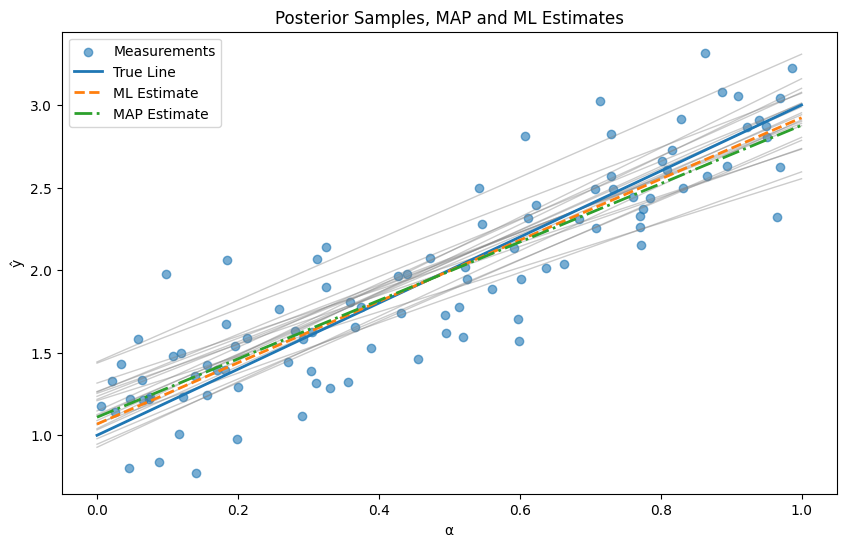

In [45]:
A_ml = np.vstack([
    np.vstack([(1 - alpha) ** 2, alpha * (1 - alpha)]),
    np.vstack([alpha * (1 - alpha), alpha ** 2])
]).reshape(2, 2, -1).sum(axis=2)

b_ml = np.array([
    np.sum((1 - alpha) * y_hat),
    np.sum(alpha * y_hat)
])

theta_ml = np.linalg.solve(A_ml, b_ml)

# Redraw the plot with posterior samples
N_samples = 20
posterior_samples = np.random.multivariate_normal(mu_posterior, cov_posterior, size=N_samples)

alpha_line = np.linspace(0, 1, 200)
y_true = (1 - alpha_line) * yI_true + alpha_line * yF_true
y_ml = (1 - alpha_line) * theta_ml[0] + alpha_line * theta_ml[1]
y_map = (1 - alpha_line) * mu_posterior[0] + alpha_line * mu_posterior[1]

plt.figure(figsize=(10, 6))
plt.scatter(alpha, y_hat, label="Measurements", alpha=0.6)

# Plot sampled lines from posterior
for sample in posterior_samples:
    y_sample = (1 - alpha_line) * sample[0] + alpha_line * sample[1]
    plt.plot(alpha_line, y_sample, color='gray', alpha=0.4, linewidth=1)

# Overlay true, ML, and MAP lines
plt.plot(alpha_line, y_true, label="True Line", linewidth=2)
plt.plot(alpha_line, y_ml, "--", label="ML Estimate", linewidth=2)
plt.plot(alpha_line, y_map, "-.", label="MAP Estimate", linewidth=2)

plt.xlabel("α")
plt.ylabel("ŷ")
plt.title("Posterior Samples, MAP and ML Estimates")
plt.legend()
plt.show()


## 4F)

### i) Vary the number of measurements as well as the variance of measurement noise
By varying the measurement count over the following domain:
1. measurement_counts = [5, 20, 100]
2. noise_variances = [0.01, 0.1, 0.5]

What was noticed was that the Bayesian estimation helps the most when, the data is few (fewer data points) OR if there is a noisy/high variance. Also from these 
conditions the MAP estimate is more stable due to the prior and the posterior spread reveals uncertainty better than if they were point estimates.

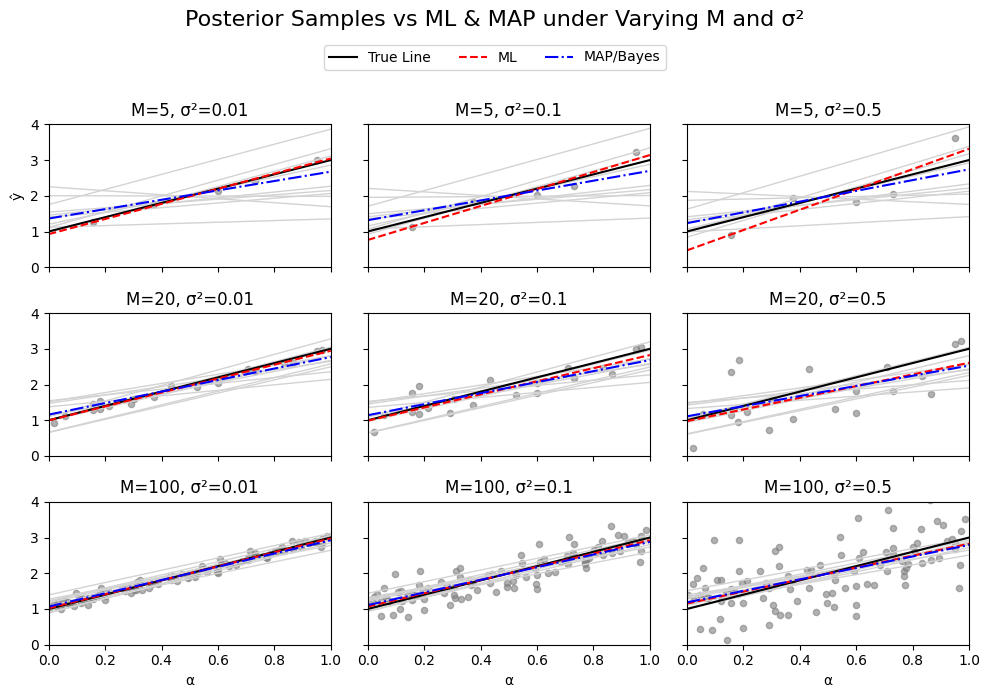

In [55]:
# True parameters and priors
yI_true, yF_true = 1.0, 3.0
mu_I, sigma_I2 = 1.5, 0.5
mu_F, sigma_F2 = 2.5, 0.5

# Grid of scenarios
measurement_counts = [5, 20, 100]
noise_variances   = [0.01, 0.1, 0.5]

alpha_line = np.linspace(0, 1, 200)
y_true = (1 - alpha_line) * yI_true + alpha_line * yF_true

fig, axes = plt.subplots(len(measurement_counts), len(noise_variances), 
                         figsize=(10, 7), sharex=True, sharey=True)

for i, M in enumerate(measurement_counts):
    for j, sigma_v2 in enumerate(noise_variances):
        sigma_v = np.sqrt(sigma_v2)
        np.random.seed(42)
        
        # Generate data
        alpha = np.random.rand(M)
        y_hat = (1 - alpha) * yI_true + alpha * yF_true + np.random.randn(M) * sigma_v
        
        # ML estimate
        A_ml = np.sum([np.array([[ (1-a)**2, a*(1-a)], [a*(1-a), a**2 ]]) for a in alpha], axis=0)
        b_ml = np.array([np.sum((1-alpha)*y_hat), np.sum(alpha*y_hat)])
        theta_ml = np.linalg.solve(A_ml, b_ml)
        
        # MAP estimate / Posterior
        A_map = A_ml + np.diag([1/sigma_I2, 1/sigma_F2])
        b_map = b_ml + np.array([mu_I/sigma_I2, mu_F/sigma_F2])
        theta_map = np.linalg.solve(A_map, b_map)
        cov_post = np.linalg.inv(A_map)
        
        # Sample from posterior
        samples = np.random.multivariate_normal(theta_map, cov_post, size=10)
        
        ax = axes[i, j]
        ax.scatter(alpha, y_hat, color='gray', s=20, alpha=0.6)
        for sample in samples:
            y_samp = (1 - alpha_line)*sample[0] + alpha_line*sample[1]
            ax.plot(alpha_line, y_samp, color='lightgray', linewidth=1)
        
        ax.plot(alpha_line, y_true, 'k-', label='True Line')
        ax.plot(alpha_line, (1-alpha_line)*theta_ml[0] + alpha_line*theta_ml[1],
                'r--', label='ML')
        ax.plot(alpha_line, (1-alpha_line)*theta_map[0] + alpha_line*theta_map[1],
                'b-.', label='MAP/Bayes')
        
        ax.set_title(f"M={M}, σ²={sigma_v2}")
        ax.set_xlim(0,1); ax.set_ylim(0,4)

# Adjust legend position above subplots but below title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize='medium')

# Main title and axis labels
fig.suptitle("Posterior Samples vs ML & MAP under Varying M and σ²", fontsize=16, y=0.99)
for ax in axes[-1]:
    ax.set_xlabel("α")
axes[0,0].set_ylabel("ŷ")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



## 4G)

### i) can the ML estimate be retrieved from the posterior ?
- No, not directly. The ML estimate ignores the prior entirely and maximizes p(D∣Θ). It is not the mode of the posterior unless the prior is flat (uninformative), or the data dominates ( meaning, very large M or very small σ²).

### ii) Can the MAP estimate be retrieved from the posterior?
- Yes, the Maximum A Posteriori (MAP) estimate can be derived from the posterior distribution. The MAP estimate is the value of the parameter that maximizes the posterior probability. 